# Phishing Email Classification

### Import modules

In [39]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Data Wrangling
import pandas as pd

# Data Visualization
import seaborn as sb
import matplotlib.pyplot as mplt

### Import Dataset

In [40]:
phishing_dt = pd.read_csv("./Phishing_Email.csv")
phishing_dt.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\r\nHello I am your hot lil horny toy.\r\n ...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


This dataset contains records where `Email Text` is set to `empty`. Such records will be removed during pre-processing as it is not helpful for the classification task.

Create a copy of the dataset for pre-processing

In [41]:
cleansed_phishing_dt = phishing_dt.copy()
print(f"Dataset shape = {cleansed_phishing_dt.shape}")

Dataset shape = (18650, 3)


Print the no. of records with `null` or `NA` values

In [42]:
cleansed_phishing_dt.isna().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

Print the no. of records where `Email Text = empty`

In [43]:
print(f"No. of records with 'Email Text' = 'empty': {cleansed_phishing_dt[cleansed_phishing_dt['Email Text'] == 'empty'].shape[0]}")

No. of records with 'Email Text' = 'empty': 533


### Pre-process data

Records with `Email Text = empty` will not be helpful for classification. So, these values will be replaced with `NA` and the `pd.dropna()` function will be invoked to cleanse the dataset.

In [44]:
cleansed_phishing_dt.replace('empty', pd.NA, inplace=True)
cleansed_phishing_dt = cleansed_phishing_dt.dropna()
cleansed_phishing_dt.isna().sum()

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64

Shape of cleansed dataset

In [45]:
print(f"Dataset shape = {cleansed_phishing_dt.shape}")

Dataset shape = (18101, 3)


Get equal no. of samples of `Safe` and `Phishing` emails

In [46]:
safe = cleansed_phishing_dt[cleansed_phishing_dt['Email Type'] == 'Safe Email']
phishing = cleansed_phishing_dt[cleansed_phishing_dt['Email Type'] == 'Phishing Email']
safe = safe.sample(phishing.shape[0])
sample_data = pd.concat([safe, phishing], ignore_index=True)
sample_data.head()

,Unnamed: 0,Email Text,Email Type
0,5214,enron japan commercial support model sally i j...,Safe Email
1,13132,"URL: http://www.newsisfree.com/click/215,9,215...",Safe Email
2,6616,\r\n> ...,Safe Email
3,9755,URL: http://jeremy.zawodny.com/blog/archives/0...,Safe Email
4,758,re : joao neves thank you vince . i look forwa...,Safe Email


### Split dataset into `train` and `test` sets

In [47]:
X = sample_data['Email Text'].values
y = sample_data['Email Type'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)

## Perform classification

### Random Forest Classifier


Training the Classifier


In [48]:
classifier = Pipeline([("tfidf", TfidfVectorizer()), ("classifier", RandomForestClassifier(n_estimators=10, random_state=23))])
classifier.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier',
                 RandomForestClassifier(n_estimators=10, random_state=23))])

Testing the Classifier


In [49]:
rf_y_pred = classifier.predict(X_test)

Model Accuracy


In [50]:
rf_accuracy = accuracy_score(y_test, rf_y_pred)
phishing_confusion_matrix = confusion_matrix(y_test, rf_y_pred)

print(f"The Random Forest Classifier has an accuracy of {rf_accuracy}")

The Random Forest Classifier has an accuracy of 0.9322475570032573


Heatmap visualization of the Confusion Matrix

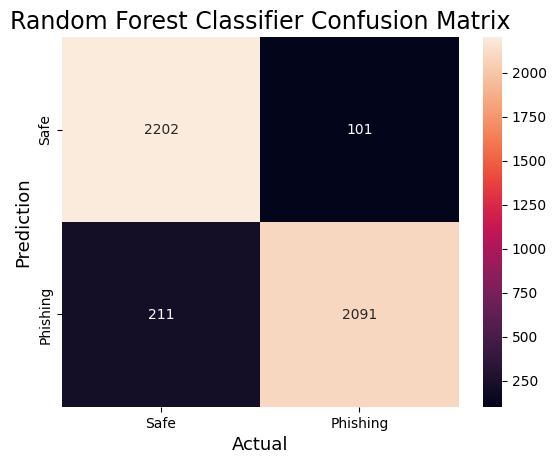

In [51]:
sb.heatmap(
    phishing_confusion_matrix,
    annot=True,
    fmt="g",
    xticklabels=["Safe", "Phishing"],
    yticklabels=["Safe", "Phishing"],
)
mplt.ylabel("Prediction", fontsize=13)
mplt.xlabel("Actual", fontsize=13)
mplt.title("Random Forest Classifier Confusion Matrix", fontsize=17)
mplt.show()

### SVM


Creating a SVM

In [52]:
svm = Pipeline([("tfidf", TfidfVectorizer()), ("SVM", SVC(C=100, gamma="auto"))])

Training the SVM

In [53]:
svm.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SVM', SVC(C=100, gamma='auto'))])

Testing the SVM

In [54]:
svm_y_pred = svm.predict(X_test)

Accuracy

In [55]:
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_confusion_matrix = confusion_matrix(y_test, svm_y_pred)

print(f'The SVM has an accuracy of {svm_accuracy}')

The SVM has an accuracy of 0.4998914223669924


Heatmap visualization of the Confusion Matrix

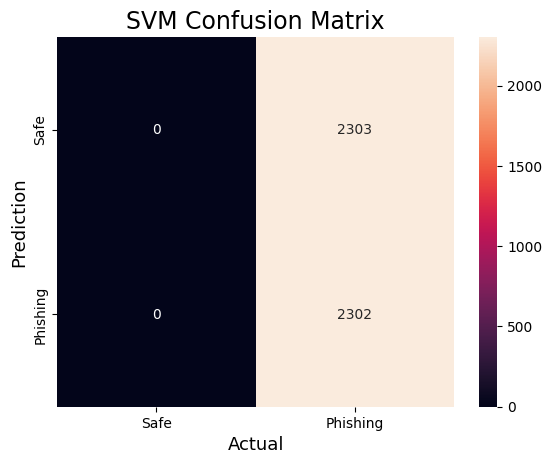

In [56]:
sb.heatmap(
    svm_confusion_matrix,
    annot=True,
    fmt="g",
    xticklabels=["Safe", "Phishing"],
    yticklabels=["Safe", "Phishing"],
)
mplt.ylabel("Prediction", fontsize=13)
mplt.xlabel("Actual", fontsize=13)
mplt.title("SVM Confusion Matrix", fontsize=17)
mplt.show()

### XGB Classifier

Creating a helper function

In [57]:
def print_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')
    print(f'Confusion Matrix: \n {confusion_matrix(y_val, y_pred)}')
    print(f'Classification Report: \n {classification_report(y_val, y_pred)}')

Define LabelEncoder and KFold for the XGB Classifier

In [58]:
label_encoder = LabelEncoder()
kfold = KFold(n_splits=5, shuffle=True, random_state=23)

Prepare data for XGB Classifier

In [59]:
xgb_sample_data = sample_data.copy()
xgb_sample_data.replace('Phishing Email', 1, inplace=True)
xgb_sample_data.replace('Safe Email', 0, inplace=True)

X_xgb = xgb_sample_data['Email Text'].values
y_xgb = xgb_sample_data['Email Type'].values

y_encoded = label_encoder.fit_transform(y)

Training and Testing the XGB Classifier

In [60]:
fold, n_estim = 1, 100
for train_index, val_index in kfold.split(X_xgb):
  X_train, X_val = X_xgb[train_index], X_xgb[val_index]
  y_train, y_val = y_encoded[train_index], y_encoded[val_index]

  vectorizer = TfidfVectorizer()
  vectorizer.fit(X_train)
  X_train = vectorizer.transform(X_train)
  X_val = vectorizer.transform(X_val)

  model = XGBClassifier(n_estimators=n_estim, learning_rate=0.1, max_depth=4, colsample_bytree=0.2, n_jobs=-1, random_state=23, enable_categorical=True)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)

  print_report(y_val, y_pred, fold)
  xgb_confusion_matrix = confusion_matrix(y_val, y_pred)
  fold += 1

Fold: 1
Accuracy Score: 0.9487638839125762
Confusion Matrix: 
 [[1369   40]
 [ 103 1279]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      1409
           1       0.97      0.93      0.95      1382

    accuracy                           0.95      2791
   macro avg       0.95      0.95      0.95      2791
weighted avg       0.95      0.95      0.95      2791

Fold: 2
Accuracy Score: 0.9530634181297026
Confusion Matrix: 
 [[1363   41]
 [  90 1297]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      1404
           1       0.97      0.94      0.95      1387

    accuracy                           0.95      2791
   macro avg       0.95      0.95      0.95      2791
weighted avg       0.95      0.95      0.95      2791

Fold: 3
Accuracy Score: 0.9444643496954497
Confusion Matrix: 
 [[1304   45]
 [ 110 1332]]
Classification Report: 
  

Heatmap visualization of the Confusion Matrix

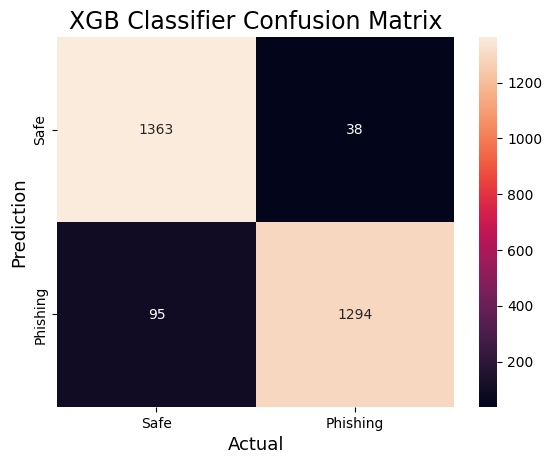

In [61]:
sb.heatmap(
    xgb_confusion_matrix,
    annot=True,
    fmt="g",
    xticklabels=["Safe", "Phishing"],
    yticklabels=["Safe", "Phishing"],
)
mplt.ylabel("Prediction", fontsize=13)
mplt.xlabel("Actual", fontsize=13)
mplt.title("XGB Classifier Confusion Matrix", fontsize=17)
mplt.show()